In [2]:
%matplotlib inline

import nengo
import tensorflow as tf
import nengo_dl
import numpy as np
import matplotlib.pyplot as plt
import random

In [28]:
with nengo.Network() as net:
    i_1 = nengo.Node(output=lambda t: random.random())
    i_2 = nengo.Node(output=lambda t: random.random())
    
#     a = nengo.Ensemble(100, 1, neuron_type=nengo.RectifiedLinear())
#     b = nengo.Ensemble(100, 1, neuron_type=nengo.RectifiedLinear())
#     nengo.Connection(i_1, a)
#     nengo.Connection(i_2, b)
    
#     c = nengo.Ensemble(220, 2, neuron_type=nengo.RectifiedLinear())
#     nengo.Connection(a, c[0])
#     nengo.Connection(b, c[1])
    
    d = nengo.Ensemble(100, 1, neuron_type=nengo.RectifiedLinear())
    nengo.Connection(i_1, d)
    nengo.Connection(i_2, d)
        
    i_1_probe = nengo.Probe(i_1)
    i_2_probe = nengo.Probe(i_2)
    output_probe = nengo.Probe(d)

In [29]:
n_steps = 8
minibatch_size = 100

Building completed in 0:00:00 
Optimization completed in 0:00:00 
Construction completed in 0:00:00 
Simulation completed in 0:00:00


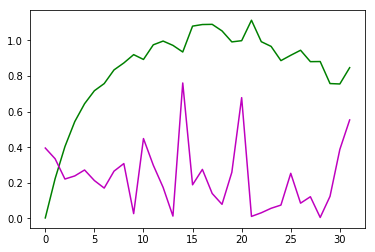

In [30]:
# Showing the output of the model pre training
with nengo_dl.Simulator(net) as sim:
    # run the simulation for 25 steps
    sim.run_steps(32)
    true_value = np.multiply(sim.data[i_1_probe], sim.data[i_2_probe])
    plt.plot(sim.data[output_probe], 'g',true_value, 'm')

Building completed in 0:00:00 
Optimization completed in 0:00:00 
Construction completed in 0:00:00 
Simulation completed in 0:00:00
[##############################] ETA: 0:00:00 (Training)
Training completed in 0:00:07
Simulation completed in 0:00:00
[##############################] ETA: 0:00:00 (Training)
Training completed in 0:00:07
Simulation completed in 0:00:00
[##############################] ETA: 0:00:00 (Training)
Training completed in 0:00:07
Simulation completed in 0:00:00
[##############################] ETA: 0:00:00 (Training)
Training completed in 0:00:07
Simulation completed in 0:00:00


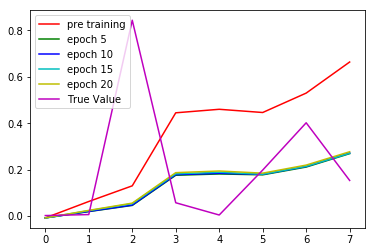

In [34]:
# Showing the trained version
with nengo_dl.Simulator(net, step_blocks=n_steps, minibatch_size=minibatch_size, device="/cpu:0") as sim:
    
    test_feed_1 = np.random.uniform(0, 1, size=(100, n_steps, 1))
    test_feed_2 = np.random.uniform(0, 1, size=(100, n_steps, 1))
    test_output = np.multiply(test_feed_1, test_feed_2)
    
    outputs = []
    sim.run_steps(n_steps, input_feeds={i_1:test_feed_1, i_2:test_feed_2})  
    outputs.append((sim.data[output_probe][0].flatten()))
    # running through 20 rounds of training, then testing
    for i in range(0, 4):
        i_1_input_feed = np.random.uniform(0, 1, size=(1000, n_steps, 1))
        i_2_input_feed = np.random.uniform(0, 1, size=(1000, n_steps, 1))
        output_feed = np.multiply(i_2_input_feed, i_1_input_feed)
        sim.train({i_1:i_1_input_feed, i_2:i_2_input_feed}, 
                  {output_probe: output_feed},
                 tf.train.MomentumOptimizer(5e-2, 0.9), n_epochs=5)
        sim.soft_reset(include_probes=True)
        sim.run_steps(n_steps, input_feeds={i_1:test_feed_1, i_2:test_feed_2})  
        outputs.append((sim.data[output_probe][0].flatten()))
        
    
    plt.plot(outputs[0], 'r', label='pre training')
    plt.plot(outputs[1], 'g', label='epoch 5')
    plt.plot(outputs[2], 'b', label='epoch 10')
    plt.plot(outputs[3], 'c', label='epoch 15')
    plt.plot(outputs[4], 'y', label='epoch 20')
    plt.plot(test_output[0].flatten(), 'm', label='True Value')
    plt.legend()